In [18]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import scikitplot as skplt
import eli5

In [2]:
def numeric_features(data, category_num_cutoff=10):
    # separate numeric and string column
    data_numeric = data.select_dtypes(exclude=['object'])
    data_string = data.select_dtypes(include=['object'])
    # discard categorical columns with more than category_num_cutoff categories
    for col in data_string:
        if data_string[col].nunique() > category_num_cutoff:
            data_string = data_string.drop(col, axis=1)
    data_string_dummies = pd.get_dummies(data_string, dummy_na=True)
    data_features = pd.concat([data_numeric, data_string_dummies], axis=1)
    return(data_features)

In [3]:
def application_composite_features(input_data):
    data = input_data.copy()
    data['INCOME_PER_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN'] + 1)
    data['CREDIT_TO_INCOME'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_TO_INCOME'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_TO_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['CREDIT_TO_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['EXT_SOURCE_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    return(data)

# Application Data

In [4]:
app_train = pd.read_csv('application_train.csv.zip')
app_train.shape

(307511, 122)

In [5]:
app_train_features = numeric_features(app_train)
app_train_features = application_composite_features(app_train_features)
app_train_features.shape

(307511, 190)

# Credit Bureau Data

In [6]:
bureau = pd.read_csv('bureau.csv.zip', compression='zip')

In [7]:
def bureau_get_features(input_data):
    data = input_data.copy()
    data.rename(columns={'AMT_ANNUITY': 'BUREAU_AMT_ANNUITY'}, inplace=True)
    data = data.loc[data['CREDIT_ACTIVE'] == 'Active']
    data = data.select_dtypes(exclude=['object'])
    data = data.groupby('SK_ID_CURR').agg(['min', 'max']).reset_index()
    data.columns = ['_'.join(col) for col in data.columns.values]
    data.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
    data.drop(['SK_ID_BUREAU_min', 'SK_ID_BUREAU_max'], axis=1, inplace=True)
    return(data)

In [8]:
bureau_features = bureau_get_features(bureau)

In [9]:
bureau_balance = pd.read_csv('bureau_balance.csv.zip', compression='zip')

# discard closed [C] and unknown status [X] and convert to integer
bureau_balance = bureau_balance[~bureau_balance['STATUS'].isin(['C', 'X'])]
bureau_balance['STATUS'] = bureau_balance['STATUS'].astype('int')

In [10]:
bureau_history12m = bureau_balance.loc[bureau_balance['MONTHS_BALANCE'] > -12,
                               ['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU').agg(['count', 'max', 'sum'])
bureau_history12m.columns = ['bureau12m_active_m', 'bureau12m_max_dpd', 'bureau12m_sum_dpd']
bureau_history12m.reset_index(inplace=True)
bureau_history12m = pd.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], bureau_history12m, on='SK_ID_BUREAU', how='left')
bureau_history12m = bureau_history12m.groupby('SK_ID_CURR').agg('sum').drop(['SK_ID_BUREAU'], axis=1).reset_index()

In [11]:
bureau_history60m = bureau_balance.loc[bureau_balance['MONTHS_BALANCE'] > -60,
                               ['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU').agg(['count', 'max', 'sum'])
bureau_history60m.columns = ['bureau60m_active_m', 'bureau60m_max_dpd', 'bureau60m_sum_dpd']
bureau_history60m.reset_index(inplace=True)
bureau_history60m = pd.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], bureau_history60m, on='SK_ID_BUREAU', how='left')
bureau_history60m = bureau_history60m.groupby('SK_ID_CURR').agg('sum').drop(['SK_ID_BUREAU'], axis=1).reset_index()

# Previous applications data

In [12]:
previous = pd.read_csv('previous_application.csv.zip', compression='zip')
previous.shape

(1670214, 37)

In [13]:
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# order df such that latest records are last
previous.sort_values(['SK_ID_CURR', 'DAYS_DECISION'], ascending=[True, True], inplace=True)

# Keep only lastest record of each current applicants
previous = previous.drop_duplicates(subset=['SK_ID_CURR'], keep='last')

# Add column name prefix to differentiate from current application
previous = previous.add_prefix('PREVAPP_')

In [15]:
previous.head()

,PREVAPP_SK_ID_PREV,PREVAPP_SK_ID_CURR,PREVAPP_NAME_CONTRACT_TYPE,PREVAPP_AMT_ANNUITY,PREVAPP_AMT_APPLICATION,PREVAPP_AMT_CREDIT,PREVAPP_AMT_DOWN_PAYMENT,PREVAPP_AMT_GOODS_PRICE,PREVAPP_WEEKDAY_APPR_PROCESS_START,PREVAPP_HOUR_APPR_PROCESS_START,...,PREVAPP_NAME_SELLER_INDUSTRY,PREVAPP_CNT_PAYMENT,PREVAPP_NAME_YIELD_GROUP,PREVAPP_PRODUCT_COMBINATION,PREVAPP_DAYS_FIRST_DRAWING,PREVAPP_DAYS_FIRST_DUE,PREVAPP_DAYS_LAST_DUE_1ST_VERSION,PREVAPP_DAYS_LAST_DUE,PREVAPP_DAYS_TERMINATION,PREVAPP_NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
935548,1564014,100004,Consumer loans,5357.250,24282.0,20106.0,4860.0,24282.0,FRIDAY,5,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
1259112,1857999,100005,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


# Combine data and model

In [16]:
record = pd.merge(app_train_features, bureau_features, on='SK_ID_CURR', how='left')
record = pd.merge(record, bureau_history12m, on='SK_ID_CURR', how='left')
record = pd.merge(record, bureau_history60m, on='SK_ID_CURR', how='left')
record = pd.merge(record, previous, left_on='SK_ID_CURR', right_on='PREVAPP_SK_ID_CURR', how='left')
record.shape

(307511, 257)

In [17]:
y = record['TARGET']
X = record.drop(['TARGET', 'SK_ID_CURR'], axis=1)

In [22]:
%%time

# Sklearn

X = X.select_dtypes(exclude='object')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

imputer = Imputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# X_resampled, y_resampled = SMOTE().fit_sample(X_train_imputed, y_train)

# model = GradientBoostingClassifier(random_state=0, n_estimators=2000)

model = GradientBoostingClassifier(random_state=0)

# model = RandomForestClassifier(random_state=0)

model.fit(X_train_imputed, y_train)


preds_class = model.predict(X_test_imputed)
preds_proba = model.predict_proba(X_test_imputed)

CPU times: user 5min 47s, sys: 2.06 s, total: 5min 49s
Wall time: 5min 49s


/home/chris/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


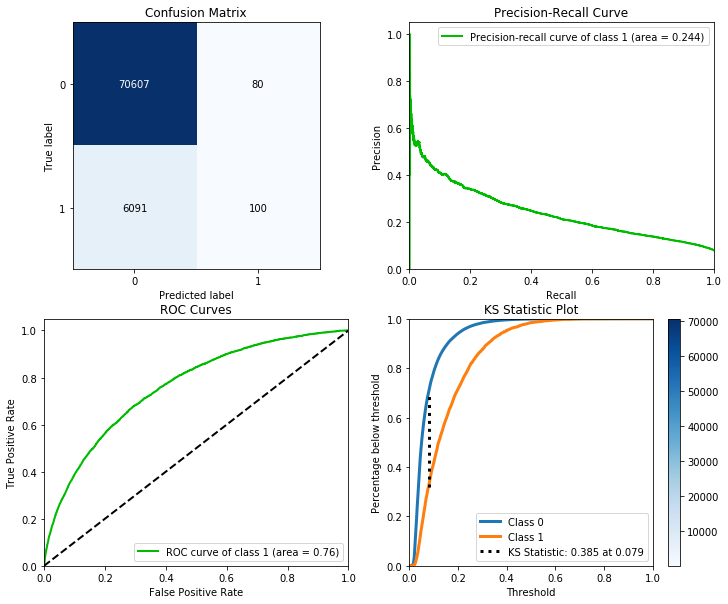

In [23]:
# Model metrics

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

skplt.metrics.plot_confusion_matrix(y_test, preds_class, ax=ax1)

skplt.metrics.plot_precision_recall(y_test, preds_proba, ax=ax2,
                                    classes_to_plot=[1], plot_micro=False);

skplt.metrics.plot_roc(y_test, preds_proba, classes_to_plot=[1], ax=ax3,
                      plot_micro=False, plot_macro=False);

skplt.metrics.plot_ks_statistic(y_test, preds_proba, ax=ax4);

In [24]:
eli5.explain_weights(model, feature_names=X.columns.values, top=15)

Weight,Feature
0.1609 ± 0.5304,EXT_SOURCE_MEAN
0.0952 ± 0.4165,CREDIT_TO_ANNUITY
0.0590 ± 0.2107,EXT_SOURCE_3
0.0459 ± 0.1691,DAYS_BIRTH
0.0431 ± 0.1575,EXT_SOURCE_2
0.0393 ± 0.1394,EXT_SOURCE_1
0.0338 ± 0.1237,DAYS_CREDIT_max
0.0332 ± 0.1678,CODE_GENDER_M
0.0318 ± 0.1317,AMT_ANNUITY
0.0275 ± 0.1199,CREDIT_TO_GOODS_PRICE


In [43]:
eli5.show_prediction(model, X_test_imputed[0], top=10, show_feature_values=True,
                        feature_names=X.columns.values, target_names=['performing', 'default'])

In [44]:
pd.DataFrame(preds_class).sort_values(0, ascending=False).head()

,0
24117,1
9392,1
26148,1
36943,1
49605,1


In [45]:
eli5.show_prediction(model, X_test_imputed[9392], top=10, show_feature_values=True,
                        feature_names=X.columns.values, target_names=['performing', 'default'])

# Submission

In [320]:
app_test = pd.read_csv('application_test.csv.zip')

In [321]:
app_test_features = numeric_features(app_test)
app_test_features = application_composite_features(app_test_features)
app_test_features.shape

(48744, 186)

In [322]:
submission_record = pd.merge(app_test_features, bureau, on='SK_ID_CURR', how='left')
submission_record = pd.merge(submission_record, bureau_history12m, on='SK_ID_BUREAU', how='left')
submission_record = pd.merge(submission_record, bureau_history60m, on='SK_ID_BUREAU', how='left')
submission_record = pd.merge(submission_record, previous, left_on='SK_ID_CURR', right_on='PREVAPP_SK_ID_CURR', how='left')

missing_columns = list(set(record.columns.values) - set(submission_record.columns.values) - set(['TARGET']))
for col in missing_columns:
    submission_record[col] = 0
    
submission_record.shape

(48744, 248)

In [323]:
# Create submission dataframe (SKlearn)

X_submission = submission_record.drop(['SK_ID_CURR'], axis=1)
X_submission = X_submission.select_dtypes(exclude='object')
X_submission_imputed = imputer.transform(X_submission)

y_submission = model.predict_proba(X_submission_imputed)
y_submission_proba1 = [a[1] for a in y_submission] #probability for class 1
submission_df = pd.DataFrame(data={'SK_ID_CURR': app_test['SK_ID_CURR'],
                                   'TARGET': y_submission_proba1})

In [324]:
submission_filename = 'submission06.csv'
submission_message = 'Fourth submission - a few more composite-features'

submission_df.to_csv(submission_filename, index=False)
!kaggle competitions submit -c home-credit-default-risk -f {submission_filename} -m "{submission_message}"

Successfully submitted to Home Credit Default Risk